# Notes on "Hindsight Credit Assignment"

I am sharing my notes from a recent paper:
> [Hindsight Credit Assignment](https://arxiv.org/abs/1912.02503). Harutyunyan et al. NeurIPS 2019.
>
> **Abstract:** We consider the problem of efficient credit assignment in reinforcement learning. In order to efficiently and meaningfully utilize new data, we propose to explicitly assign credit to past decisions based on the likelihood of them having led to the observed outcome. This approach uses new information in hindsight, rather than employing foresight. Somewhat surprisingly, we show that value functions can be rewritten through this lens, yielding a new family of algorithms. We study the properties of these algorithms, and empirically show that they successfully address important credit assignment challenges, through a set of illustrative tasks.

"Life can only be understood backwards; but it must be lived forwards." $-$ Søren Kierkegaard

Links from the authors:
* [code](https://github.com/hca-neurips2019/hca/blob/master/hca_classes.py)
* [poster](https://pbs.twimg.com/media/ELB5Y21WoAUt6hg?format=jpg&name=4096x4096)
* [video](https://www.youtube.com/watch?v=2EnckznIV2o&ab_channel=AnnaHarutyunyan)

Follow-up papers:
* [Forethought and Hindsight in Credit Assignment](https://arxiv.org/abs/2010.13685)
* https://arxiv.org/pdf/2011.09464.pdf
* https://arxiv.org/pdf/2011.09464.pdf

Related ideas:
* [Improving Policy Gradient Estimates with Influence Information](http://proceedings.mlr.press/v20/pinto11/pinto11.pdf)

Background and extra reading:
* [Dual Representations for Dynamic Programming](https://webdocs.cs.ualberta.ca/~dale/papers/dualdp.pdf)
* Peter Dayan (1993) [Improving Generalisation for Temporal Difference Learning: The Successor Representation](http://www.gatsby.ucl.ac.uk/~dayan/papers/d93b.pdf)

To better engage with the content of the paper, I am going to implement the core ideas in Python making use of my personal libraries [rl](https://github.com/timvieira/rl) and [arsenal](https://github.com/timvieira/arsenal).

$$
\newcommand{\expect}[2]{\underset{\substack{#1}}{\mathbb{E}}\left[ #2 \right]}
\newcommand{\Pr}[1]{\mathrm{Pr}\!\left[ #1 \right]}
$$

## How is HCA used?

The paper builds up to a tweak to the policy gradient updates.

The golden goose is
$$
\nabla J = \expect{s_1 a_1 r_1 \ldots s_T a_T r_T}{\sum_{t=1}^T \left( Q(s_t) - b(s_t) \right) \nabla \log \pi(a_t \mid s_t)}
$$

the $b$ function is optional.

The REINFORCE estimator is
$$
\nabla J \approx \sum_{t=1}^T \left( \sum_{t'=t}^{T} r_{t'} - b(s_t) \right) \nabla \log \pi(a_t \mid s_t)
$$

The proposed modification is
$$
\nabla J \approx \sum_{t=1}^T \left( \sum_{t'=t}^{T} r_{t'} I(s_t, a_t, r_{t'}) \right) \nabla \log \pi(a_t \mid s_t)
$$

Again, the $b$ function is optional.

where $I(s_t, a_t, r_{t'})$ is a (positive or negative) "importance weighting" factor that is supposed to be large when $a_t$ has very important to the downstream reward $r_{t'}$.  Interestingly, their estimator does not require/benefit from a $b$ function.

The specific choice they use is

$$
I(s_t, a_t, r_{t'}) = \left( \frac{\Pr{r_{t'} \mid s_t, a_t}}{ \Pr{r_{t'} \mid s_t} } - 1 \right)
$$

which they show is unbiased.

$$
\expect{r_{t'} \sim \Pr{\cdot \mid s_t} }{ r_{t'} \left( \frac{\Pr{r_{t'} \mid s_t, a_t}}{ \Pr{r_{t'} \mid s_t} } - 1 \right) }
= \expect{r_{t'}}{ r_{t'} \mid s_t, a_t } - \expect{r_{t'}}{ r_{t'} \mid s_t}
= Q(s_t, a_t) - V(s_t)
$$

Here we take $b = V$.

In the paper, they suggest learning the quantities $\frac{\Pr{r_{t'} \mid s_t, a_t}}{\Pr{r_{t'} \mid s_t}}$ which they break up as $\frac{h(a_t, \mid s_t, r_{t'})}{\pi(a_t \mid s_t)}$ where $h$ is essentially a probabilistic classifier that says given that is trained on triplets $\langle a_t, s_t, r_{t'} \rangle$ to maximize likelihood.

## Some related work that was missing...

Pinto's influence functions - Comes from the same intuition.  Similar, but restricted as it requires prior knowledge of the work.  Furthermore, it a *binary* version of $I$.  Related to Pinto is stochastic computation graphs, which are just another formalism for deriving influence relations.

## Theory?

While it's nice to have another unbiased estimator in the literature, I do not believe the approach necessarily provides an improvement to the quality of the estimator, i.e., it's variance may *increase* relative to the REINFORCE estimator.  The issue is that the importance weights can be very large.  I experiment with some randomly generated MDPs below and find that the weights are often very large.

Unfortunately, the experiments could not be more toy.  They really cooked them to work very well.

# Trying it out...

In [1]:
import numpy as np, matplotlib.pyplot as pl
from rl.mdp import DiscountedMDP, random_MDP, random_dist
from arsenal import iterview

In [2]:
def ShortcutMDP(S):
    A = 2
    P = np.zeros((S,A,S))
    end = S-1
    for i in range(S):
        P[i,0,min(i+1,end)] = 1    # step forward one state
        P[i,1,end] = 1             # the 'shortcut' action that jumps to the end

    s0 = np.zeros(S)
    s0[0] = 1
    
    R = np.zeros((S,A,S))
    R[:,:,end] = 1   # reward of one at the final state, zero elsewhere
    R[end,:,end] = 0
    
    M = DiscountedMDP(s0=s0, P=P, R=R, γ=0.9)
    M.check()
    
    return M

In [3]:
def DelayedEffect(T):    
    S = 2*(T+1)
    A = 2
    P = np.zeros((S,A,S))
    
    # start state = 0
    P[0, 0, 1] = 1   # odd numbered states
    P[0, 1, 2] = 1   # even numbered states
    
    final_even = 2*T; final_odd = 2*T+1
        
    for t in range(0, T+1):
        if t != 0:
            k = min(final_even, 2*(t+1))
            P[2*t, 0, k] = 1   
            P[2*t, 1, k] = 1
        k = min(final_odd, 2*(t+1)+1)
        P[2*t+1, 0, k] = 1
        P[2*t+1, 1, k] = 1

    s0 = np.zeros(S)
    s0[0] = 1
    
    R = np.zeros((S,A,S))
    R[:,:,final_even] = 1
    R[:,:,final_odd] = -1
    R[final_even,:,final_even] = 0
    R[final_odd,:,final_odd] = 0
    
    M = DiscountedMDP(s0=s0, P=P, R=R, γ=0.9)
    M.check()
    
    return M

In [4]:
M = random_MDP(S=10, A=3, b=3, γ=0.85)
#M = ShortcutMDP(10)
#M = DelayedEffect(5)

**Populate the universe of discourse**

In [5]:
π = policy = random_dist(M.S, M.A)

S = range(M.S); A = range(M.A)          # set of states and set of actions
γ = M.γ
V = M.V(π)
Q = M.Q(π)
Adv = M.Advantage(π)
R = M.r
P = M.P

MM = (M | π)
RR = MM.R
PP = MM.P

policy = π
gamma = γ

Π = M.Π(π)

#### The successor representation $P(k \mid i)$

The distribution $P(k \mid i)$ is known as the **successor representation** (Dayan, 1993).

It is often represented as an $\mathcal{S} \times \mathcal{S}$ matrix, $F$, that is the solution to the linear recurrence:

$$
F(i,k) = (1-\gamma) 1(i=k) + \gamma \, \sum_a \sum_j F(j, k) \, P(j \mid i, a)\, \pi(a \mid i)
$$

Let's write it in vector form so that we can solve it with linear algebra.

First, let $P_\pi(i, j) = P(j \mid i, a)\, \pi(a \mid i)$.

$$
\begin{align}
F &= (1-\gamma) I + \gamma\, P_\pi F  \\
F - \gamma P_\pi F &= (1-\gamma) I \\
(I - \gamma P_\pi) F &= (1-\gamma) I \\
F &= (I - \gamma P_\pi)^{-1} (1-\gamma)
\end{align}
$$

In [6]:
F = M.successor_representation(π, normalize=True)

In [7]:
# sanity check: We solved the equations
assert np.allclose(F, (1-γ) * np.eye(M.S) + γ * PP @ F)

Lemma: $\sum_{k} F(i, k) = 1$ for all $i \in \mathcal{S}$.

In [8]:
assert np.allclose(np.einsum('ik->i', F), 1) 

We can recover the value function as

$$
V = \frac{1}{1-\gamma}\, F\, r_{\pi} = V = \frac{1}{1-\gamma} \expect{k \sim F(i,\cdot) \\ c \sim \pi(\cdot \mid k)}{ r(k,c) }
$$

In [9]:
assert np.allclose(V, F @ RR / (1-γ))

**Now, back to thinking about actions...**

How might we write the $Q$ function in terms of $F$?
$$
\begin{align}
Q(i,a) 
&= r(i,a) + \gamma \sum_{j} V(j) P(j \mid i, a) \\
&= r(i,a) + \frac{\gamma}{1-\gamma} \sum_{j} \left( \sum_{k} \sum_c \pi(c \mid k) r(k,c) F(j, k) \right) P(j \mid i, a)
\end{align}
$$

In [10]:
assert np.allclose(Q, R + γ/(1-γ) * np.einsum('iaj,jk,kc,kc->ia', P, F, policy, R))

This is a little clunky in my opinion.  Let's try using a Markov chain over state$-$actions pairs.  So that we can write $Q$ as a simple expectation like we did for $V$. Let $W$ be the successor representation defined on the state$-$action Markov chain.

Sidenote: $W$ is known as the **dual matrix representation** [(Wang+,2008,Eq.15)](https://webdocs.cs.ualberta.ca/~dale/papers/dualdp.pdf) and it can be found by solving an analogous linear recurrence.  It is also a valid distribution over k,c given i,a.

$$
\newcommand{\tup}[1]{\langle#1\rangle}
Q(i,a) 
= \frac{1}{1-\gamma} \sum_{k,c} r(k,c) W(\tup{i, a}, \tup{k, c})
= \expect{\langle k,c\rangle \sim W(\tup{i, a}, \cdot)}{ R(k,c) } \\
$$


In [11]:
W = M.sasa_matrix(π, normalize=True)
assert np.allclose(1, np.einsum('iakc->ia', W))
assert np.allclose(F @ Π, Π @ W.reshape(M.S*M.A, M.S*M.A))

In [12]:
# W ==> F
assert np.allclose(F, np.einsum('iakc,ia->ik', W, π))

### Hindsight: inverting the trajectory by Bayes Rule

$\Pr{\mathrm{Outcome} \mid i, a}$ can be inverted by Bayes rule to get a distribution over actions, which will be the key idea behind the counterfactual question of how responsible was action $a$ in state $x$ in land at the distant state $z$?  If there are many ways that $x$ can get to $z$ then we don't really need $a$ to get there. 

$$
\Pr{a \mid i, \mathrm{Outcome}} 
\overset{\mathrm{(Bayes\ rule)}}{=} \frac{ \Pr{\mathrm{Outcome} \mid a, i} \Pr{a \mid i} }{ \Pr{\mathrm{Outcome} \mid i} }
= \frac{ \Pr{\mathrm{Outcome} \mid a, i} \pi(a \mid i) }{ \Pr{\mathrm{Outcome} \mid i} }
$$

Notes: If $\Pr{k \mid i}=0$, we can end up with a divide-by-zero situation. Luckily, when it comes time to use this expression, we will see that $\Pr{k \mid i}=0$ is never queried because all $i \leadsto k$ paths are sampled from $\Pr{k \mid i}$.

In [13]:
WW = np.einsum('iakc,ia->ikc', W, policy)
w = np.zeros((M.S, M.A, M.S, M.A))
for i in S:
    for k in S:
        for a in A:
            for c in A:
                w[i,a,k,c] = W[i,a,k,c]*π[i,a]/WW[i,k,c] if WW[i,k,c] > 0 else np.nan

In [14]:
# Check the validity of the hindsight action distribution
for i in S:
    for k in S:
        got = sum(w[i,a,k,c] for a in A)
        assert np.allclose(1, got) or np.isnan(got)

In [15]:
QQ = Q*0; VV = V*0; AA = Adv*0
for i in S:    
    VV[i] = 1/(1-γ)*sum(W[i,a,k,c] * R[k,c] * policy[i,a] for c in A for k in S for a in A)    
    for a in A:
        QQ[i,a] = 1/(1-γ)*sum(W[i,a,k,c] * R[k,c] for c in A for k in S)
        AA[i,a] = 1/(1-γ)*(sum((W[i,a,k,c] - WW[i,k,c]) * R[k,c] for c in A for k in S))
assert np.allclose(QQ, Q)
assert np.allclose(VV, V)
assert np.allclose(Adv, AA)

In [16]:
assert np.allclose(1, np.einsum('ikc->i', WW))

Influence = np.zeros((M.S, M.A, M.S, M.A))
for i in S:
    for a in A:
        for k in S:
            for c in A:
                if WW[i,k,c] == 0: 
                    #Influence[i,a,k,c] = np.nan
                    continue
                Influence[i,a,k,c] = w[i,a,k,c]/policy[i,a] - 1
                
                # An equivalent expression is
                #   Influence[i,a,k,c] = W[i,a,k,c]/WW[i,k,c] - 1
                assert np.allclose(W[i,a,k,c]/WW[i,k,c], w[i,a,k,c]/policy[i,a])


In [17]:
AA = Adv*0
for i in S:
    for a in A:
        AA[i,a] = 1/(1-γ)*sum(WW[i,k,c] * Influence[i,a,k,c] * R[k,c] for c in A for k in S)
assert np.allclose(Adv, AA)

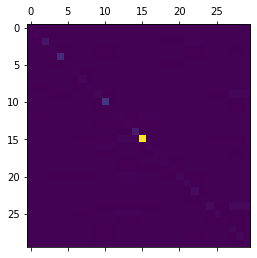

In [18]:
foo = []
for s in range(M.S):
    for a in range(M.A):
        foo.append(Influence[s,a].flatten())
pl.matshow(foo);

In [19]:
for rank, (_, infl, i, a, k, c) in enumerate(sorted([
    (-abs(Influence[i,a,k,c]), Influence[i,a,k,c], i, a, k, c)
        for i in S for a in A for k in S for c in A
])):
    print(f'{infl:.3f}', (i, a), (k, c))
    if rank > 15: break

195.288 (5, 0) (5, 0)
30.503 (3, 1) (3, 1)
23.124 (1, 1) (1, 1)
14.027 (4, 2) (4, 2)
10.829 (0, 2) (0, 2)
4.777 (7, 1) (7, 1)
4.004 (8, 0) (8, 0)
3.058 (8, 0) (9, 0)
3.058 (8, 0) (9, 1)
3.058 (8, 0) (9, 2)
2.795 (9, 1) (9, 1)
2.553 (3, 0) (3, 0)
2.159 (7, 0) (7, 0)
2.026 (3, 0) (9, 2)
2.026 (3, 0) (9, 0)
2.026 (3, 0) (9, 1)
1.741 (9, 2) (9, 2)


Interestingly, the ratio is flipped in the case of the value function!  We have to be a little careful in this case to avoid zero probability events.

In [20]:
# TODO: bring back this test
#AA = Adv*0
#for i in S:
#    for a in A:
#        AA[i,a] = 1/(1-γ)*sum(WW[i,k,c] * (1 - π[i,a]/w[i,a,k,c]) * R[k,c] for k in S for c in A)
#compare(Adv, AA).show()

In [21]:
def qvn(q, v, n_sa):
    "Helper function to build advantage estimation from the pieces passed in."
    n_s = n_sa.sum(axis=1)
    adv1 = np.zeros((M.S, M.A))
    for s in S:
        for a in A:
            adv1[s,a] = q[s,a]/n_sa[s,a] - v[s]/n_s[s]
    return adv1

In [22]:
def run(samples: 'number of samples' = 100_000, trunc: 'truncate updates after this many steps' = 50):
    adv = np.zeros((M.S, M.A)); n_sa = np.zeros((M.S, M.A)) + 1
    q = np.zeros((M.S, M.A)); v = np.zeros(M.S)
    sim = iter(M.simulate(π, mode='reset'))
    trajectory = []
    
    z_infl = 0.0
    n_infl = 0
    
    for _ in iterview(range(samples)):
        (k,c,r) = next(sim)
        n_sa[k,c] += 1
        trajectory.append((k,c,r))
        
        # Looking backwards on the trajectory so far...
        for tt, (i, a, _) in enumerate(reversed(trajectory), start=0):
            if tt > trunc: break
                
            # monte carlo method
            q[i, a] += r; v[i] += r

            # hindsight methods
            infl = Influence[i,a,k,c]
            if 1:
                # Hack: clipping the influence weights to [-1, +1]
                sign = +1 if infl > 0 else -1
                infl = sign * min(1, abs(infl))
            adv[i, a] += r * infl

    return adv, q, v, n_sa

adv, q, v, n_sa = run()

100.0% (100000/100000) [==============================================] 00:00:17


0.10357984188077567 -0.01156825026238158

Comparison (hindsight): n=30
  norms: [1.1847, 6.80415]
  pearson: 0.590742
  spearman: 0.623582
  ℓ∞: 3.15482
  ℓ₂: 6.18159
  same-sign: 76.66666666666667% (23/30)
  regression: [0.104 -0.012] R=0.956

0.34003223362804336 0.022397760100543902

Comparison (monte carlo): n=30
  norms: [1.1847, 1.66583]
  pearson: 0.470387
  spearman: 0.762848
  ℓ∞: 1.4995
  ℓ₂: 1.53783
  same-sign: 90.0% (27/30)
  regression: [0.340 0.022] R=1.045



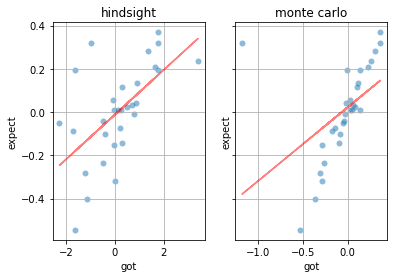

In [23]:
_, ax = pl.subplots(ncols=2, sharex=False, sharey=True)
c1 = compare(Adv, adv/n_sa, name='hindsight').plot(ax=ax[0]);
c2 = compare(Adv, qvn(q, v, n_sa), name='monte carlo').plot(ax=ax[1]);

In [24]:
def render(M):
    from IPython.core.display import display, HTML
    import os, tempfile
    def name(s): return f'{s}'
    def edge_sty(s, a, r, sp): return 'black', f'{a} -> {M.P[s,a,sp]:.2f}: {r:.1f}'

    with open('mdp.dot', 'w') as f:    # TODO: write to tmp file too like the stuff below.
        f.write('digraph MDP {\n')
        for s in range(M.S):
            for a in range(M.A):
                for sp in range(M.S):
                    if M.P[s,a,sp] == 0: continue
                    r = M.R[s,a,sp]
                    #if policy[s,a] > 0:
                    c, label = edge_sty(s, a, r, sp)
                    f.write(f"""
                    "{name(s)}" -> "{name(sp)}" [color={c}, label="{label}", fontcolor="{c}"];
                    """)
        f.write('}')
    
    svg = tempfile.NamedTemporaryFile(prefix='/tmp/mdp-', suffix='.svg', delete=False)
    if os.system(f'cat {f.name} |dot -Tsvg > {svg.name}'):   # exit code 0 is success.
        print(colors.light.red % 'graphviz failed')

    return HTML(svg.name)

In [25]:
render(M)

In [26]:
render(ShortcutMDP(10))

In [27]:
render(DelayedEffect(5))